# Group 2: Dekker, Hauser, Tassone, Vogel

## Introductory part
e.g. loading packages, reading data, EDA

In [1]:
##### packages
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


import math
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pingouin as pg
from pingouin import multivariate_normality
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from missingpy import MissForest
from impyute.imputation.cs import mice

C:\Users\Aaron\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [50]:
##### reading the data
df14 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2014_Financial_Data.csv')
df15 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2015_Financial_Data.csv')
df16 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2016_Financial_Data.csv')
df17 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2017_Financial_Data.csv')
df18 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/2018_Financial_Data.csv')

df_sp500 = pd.read_csv('https://raw.githubusercontent.com/AtK42/ML_stonks_2021/main/Data/sp-500-historical-annual-returns-modified.csv')

In [51]:
##### df manipulation

#add column with year
df14['year'] = 2014
df15['year'] = 2015
df16['year'] = 2016
df17['year'] = 2017
df18['year'] = 2018

#add column for recommendation
df14['recommendation'] = 0
df15['recommendation'] = 0
df16['recommendation'] = 0
df17['recommendation'] = 0
df18['recommendation'] = 0

#rename 'Price Var' col
df14.rename(columns={"2015 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df15.rename(columns={"2016 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df16.rename(columns={"2017 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df17.rename(columns={"2018 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)
df18.rename(columns={"2019 PRICE VAR [%]": "PRICE_VAR", "Unnamed: 0":"Stock"},inplace=True)

df14.index = df14.Stock
df15.index = df15.Stock
df16.index = df16.Stock
df17.index = df17.Stock
df18.index = df18.Stock

#dropping name column
# df14 = df14.drop(df14.columns[0], axis=1)
# df15 = df15.drop(df15.columns[0], axis=1)
# df16 = df16.drop(df16.columns[0], axis=1)
# df17 = df17.drop(df17.columns[0], axis=1)
# df18 = df18.drop(df18.columns[0], axis=1)


#create a list with all raw data
df_all = pd.concat([df14, df15, df16, df17, df18], ignore_index=True)

In [4]:
##### some minor EDA

df14.columns
df14.info() #we have mostly floats, but also 3 integer variables and 2 object variables (possible to use e.g. 'One-Hot-Encoding' or 'LabelEncoding' for object variable)
df14['Class']
df14.describe()

#check which are the integer and object variables
df14.select_dtypes(include = ['integer']) #class, year & recommendation
df14.select_dtypes(include = ['object']) #sector

#having a look at the other years
df15.info()
df16.info()
df17.info()
df18.info()

#dimensions for each data set
year = 14
for el in [df14, df15, df16, df17, df18]:
    print(year, el.shape)
    year += 1

Index(['Stock', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Asset Growth', 'Book Value per Share Growth', 'Debt Growth',
       'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector', 'PRICE_VAR',
       'Class', 'year', 'recommendation'],
      dtype='object', length=227)

<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, PG to WTT
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 6.6+ MB


Stock
PG       0
VIPS     0
KR       1
RAD      1
GIS      1
        ..
TSRI     1
TZOO     0
USATP    0
WSTG     1
WTT      0
Name: Class, Length: 3808, dtype: int64

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE_VAR,Class,year,recommendation
count,3.764000e+03,3572.000000,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.745000e+03,3.728000e+03,...,3518.000000,3518.000000,3439.000000,3506.000000,3561.000000,3565.000000,3.808000e+03,3808.000000,3808.0,3808.0
mean,5.879050e+09,12.954244,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,1.438144e+09,6.748248e+08,1.002018e+08,5.725866e+08,...,0.164692,2.279999,0.813931,1.361780,0.596529,0.382284,9.751560e+02,0.429097,2014.0,0.0
std,3.901741e+10,705.605473,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.305171e+09,3.786291e+09,6.991091e+08,2.793740e+09,...,2.195115,92.428920,25.630214,18.734301,25.894049,4.696975,4.098461e+04,0.495012,0.0,0.0
min,-6.276160e+08,-1.773200,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-1.088448e+09,-6.786000e+09,-2.250000e+08,-8.878000e+09,...,-1.000000,-0.979600,-230.000000,-1.051000,-1.043700,-1.000000,-1.003972e+02,0.000000,2014.0,0.0
25%,5.788880e+07,-0.002350,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,...,0.000000,-0.015400,-0.084550,-0.048200,0.000000,-0.003900,-2.857143e+01,0.000000,2014.0,0.0
50%,4.349010e+08,0.061850,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386610e+08,4.104400e+07,2.563000e+06,2.842700e+07,...,0.000000,0.062200,0.037100,0.000000,0.000000,0.068800,-5.281842e+00,0.000000,2014.0,0.0
75%,2.393625e+09,0.188875,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,...,0.063850,0.217100,0.141900,0.210300,0.004700,0.220500,1.331484e+01,1.000000,2014.0,0.0
max,1.824698e+12,42138.663900,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,76.625000,5468.426400,1360.125000,729.576600,1542.611000,225.690000,2.418601e+06,1.000000,2014.0,0.0


,Class,year,recommendation
Stock,,,
PG,0,2014,0
VIPS,0,2014,0
KR,1,2014,0
RAD,1,2014,0
GIS,1,2014,0
...,...,...,...
TSRI,1,2014,0
TZOO,0,2014,0
USATP,0,2014,0


,Stock,Sector
Stock,,
PG,PG,Consumer Defensive
VIPS,VIPS,Consumer Defensive
KR,KR,Consumer Defensive
RAD,RAD,Consumer Defensive
GIS,GIS,Consumer Defensive
...,...,...
TSRI,TSRI,Technology
TZOO,TZOO,Technology
USATP,USATP,Technology


<class 'pandas.core.frame.DataFrame'>
Index: 4120 entries, PG to WTT
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4797 entries, PG to WTT
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4960 entries, PG to WTT
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 8.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, CMCSA to ZYME
Columns: 227 entries, Stock to recommendation
dtypes: float64(222), int64(3), object(2)
memory usage: 7.6+ MB
14 (3808, 227)
15 (4120, 227)
16 (4797, 227)
17 (4960, 227)
18 (4392, 227)


## Missing Values/NAs

### Analysis
* firstly, we have a look at how many missing values we have for which variable (also adding some graphs)
* secondly, we look at variables with an unusual high NA count
* next, we implement a first imputer (KNN) and then fit a very naive classification tree to see which variables the model would choose (without any restrictions, only depth=4), bear in mind that this is done at a very basic level and the results of this should looked at rather critically (on the level of meaningfulness)
* then, we drop the variables with high NA count and which are not used in the naive decision tree

In [5]:
##### check missing values
df14.isnull().sum().sum()
df15.isnull().sum().sum()
df16.isnull().sum().sum()
df17.isnull().sum().sum()
df18.isnull().sum().sum()
df_all.isnull().sum().sum()

101103

114348

212549

226269

97298

751567

['operatingCycle', 'cashConversionCycle', 'cashFlowToDebtRatio', 'cashFlowCoverageRatios', 'shortTermCoverageRatios', '10Y Revenue Growth (per Share)', '10Y Operating CF Growth (per Share)', '10Y Net Income Growth (per Share)', '10Y Shareholders Equity Growth (per Share)', 'priceEarningsToGrowthRatio', 'niperEBT', 'effectiveTaxRate', 'nIperEBT', 'dividendPayoutRatio', 'Net Debt to EBITDA', '10Y Dividend per Share Growth (per Share)', 'Total non-current assets', 'Total non-current liabilities', 'Net Debt', 'Other Assets', 'priceCashFlowRatio', 'enterpriseValueMultiple', 'ebtperEBIT', 'returnOnAssets', 'returnOnCapitalEmployed', 'eBTperEBIT', 'freeCashFlowOperatingCashFlowRatio', 'Current ratio', 'ROIC', 'Return on Tangible Assets', 'Working Capital', '5Y Revenue Growth (per Share)', '5Y Operating CF Growth (per Share)', '5Y Net Income Growth (per Share)', '5Y Shareholders Equity Growth (per Share)', '5Y Dividend per Share Growth (per Share)']


36

Stock                                         0.000000
Class                                         0.000000
PRICE_VAR                                     0.000000
Sector                                        0.000000
year                                          0.000000
                                                ...   
10Y Revenue Growth (per Share)                0.431762
10Y Shareholders Equity Growth (per Share)    0.438465
shortTermCoverageRatios                       0.486660
operatingCycle                                0.999139
cashConversionCycle                           0.999139
Length: 227, dtype: float64

<Figure size 7200x2160 with 0 Axes>

<BarContainer object of 227 artists>

Text(0, 0.5, 'percentage missing values')

([<matplotlib.axis.XTick at 0x1ec807c7340>,
 [Text(1, 0, 'Stock'),
  Text(2, 0, 'Revenue'),
  Text(3, 0, 'Revenue Growth'),
  Text(4, 0, 'Cost of Revenue'),
  Text(5, 0, 'Gross Profit'),
  Text(6, 0, 'R&D Expenses'),
  Text(7, 0, 'SG&A Expense'),
  Text(8, 0, 'Operating Expenses'),
  Text(9, 0, 'Operating Income'),
  Text(10, 0, 'Interest Expense'),
  Text(11, 0, 'Earnings before Tax'),
  Text(12, 0, 'Income Tax Expense'),
  Text(13, 0, 'Net Income - Non-Controlling int'),
  Text(14, 0, 'Net Income - Discontinued ops'),
  Text(15, 0, 'Net Income'),
  Text(16, 0, 'Preferred Dividends'),
  Text(17, 0, 'Net Income Com'),
  Text(18, 0, 'EPS'),
  Text(19, 0, 'EPS Diluted'),
  Text(20, 0, 'Weighted Average Shs Out'),
  Text(21, 0, 'Weighted Average Shs Out (Dil)'),
  Text(22, 0, 'Dividend per Share'),
  Text(23, 0, 'Gross Margin'),
  Text(24, 0, 'EBITDA Margin'),
  Text(25, 0, 'EBIT Margin'),
  Text(26, 0, 'Profit Margin'),
  Text(27, 0, 'Free Cash Flow margin'),
  Text(28, 0, 'EBITDA'),
  T

<AxesSubplot:>

0.09802056438827739

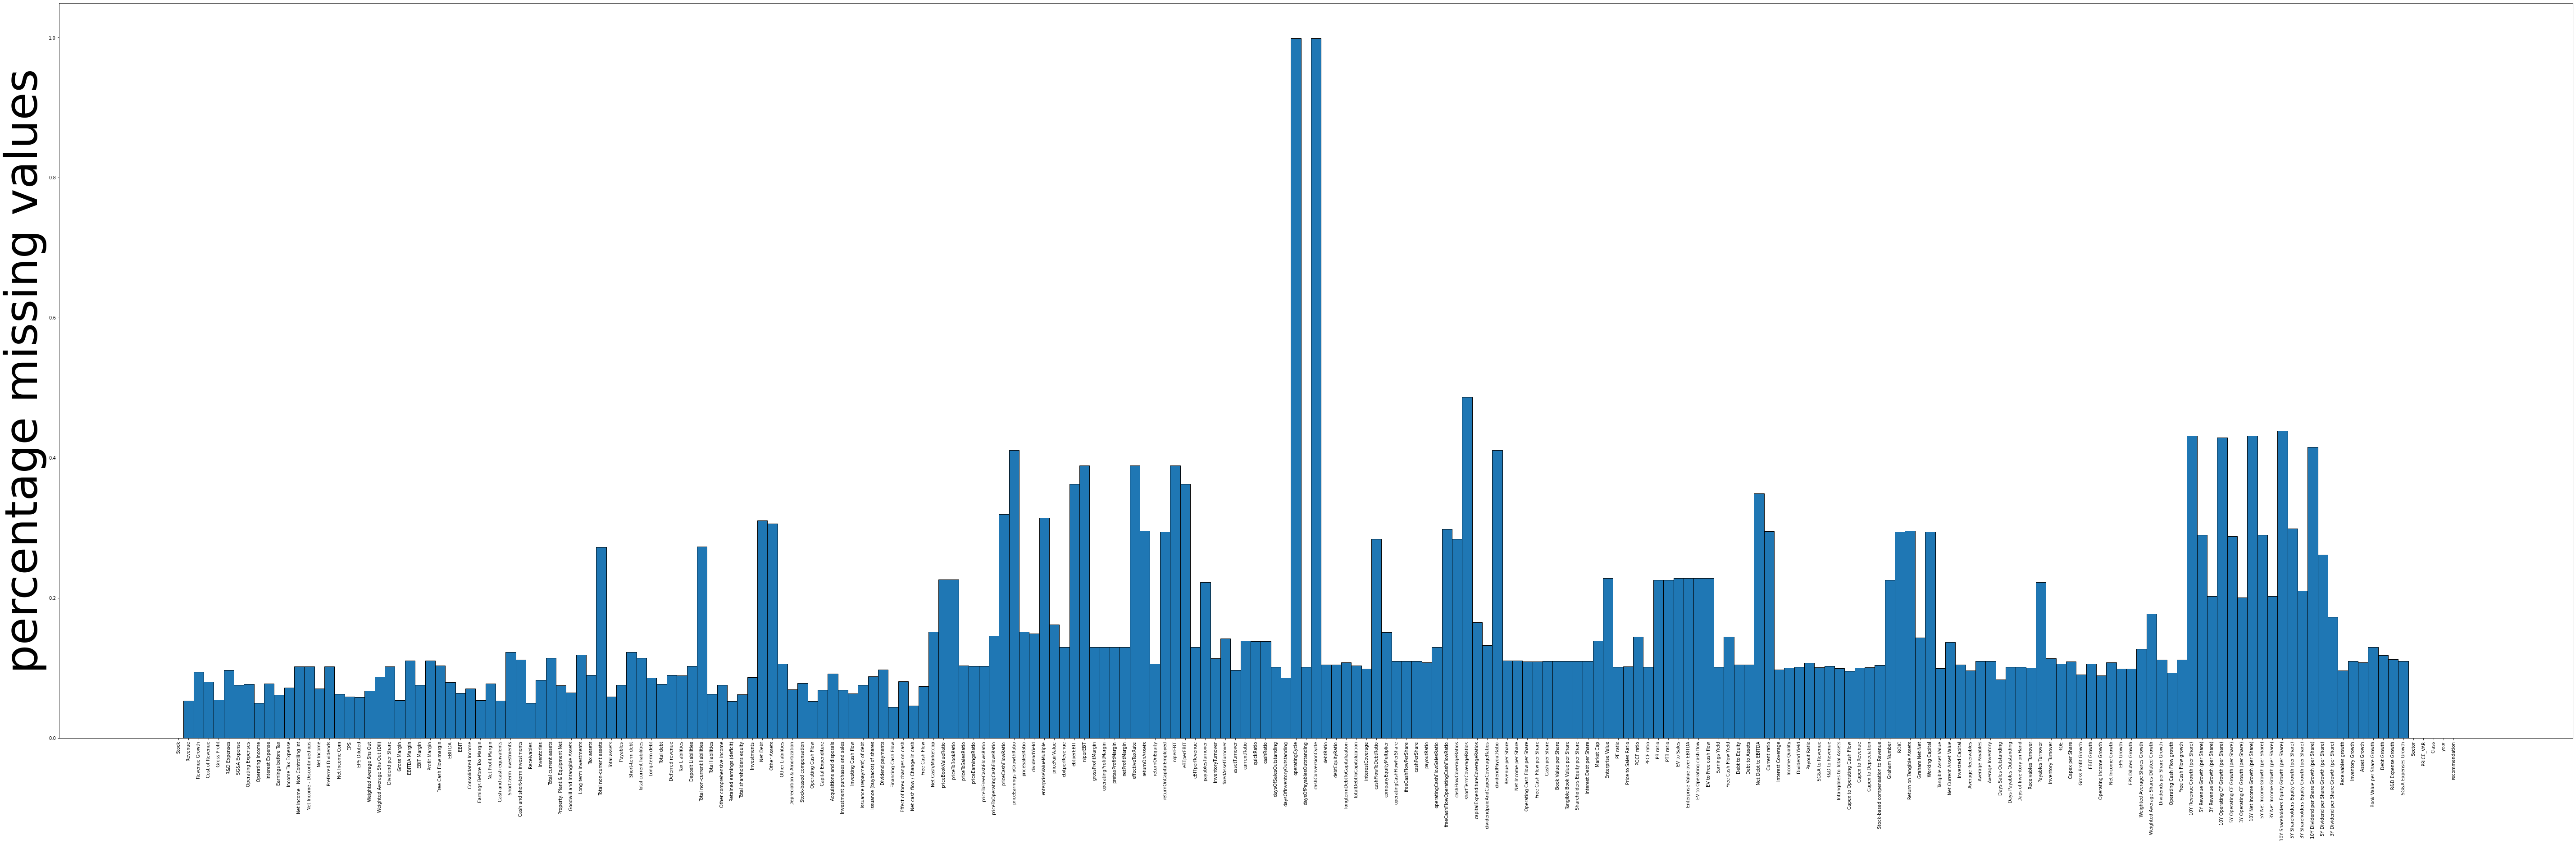

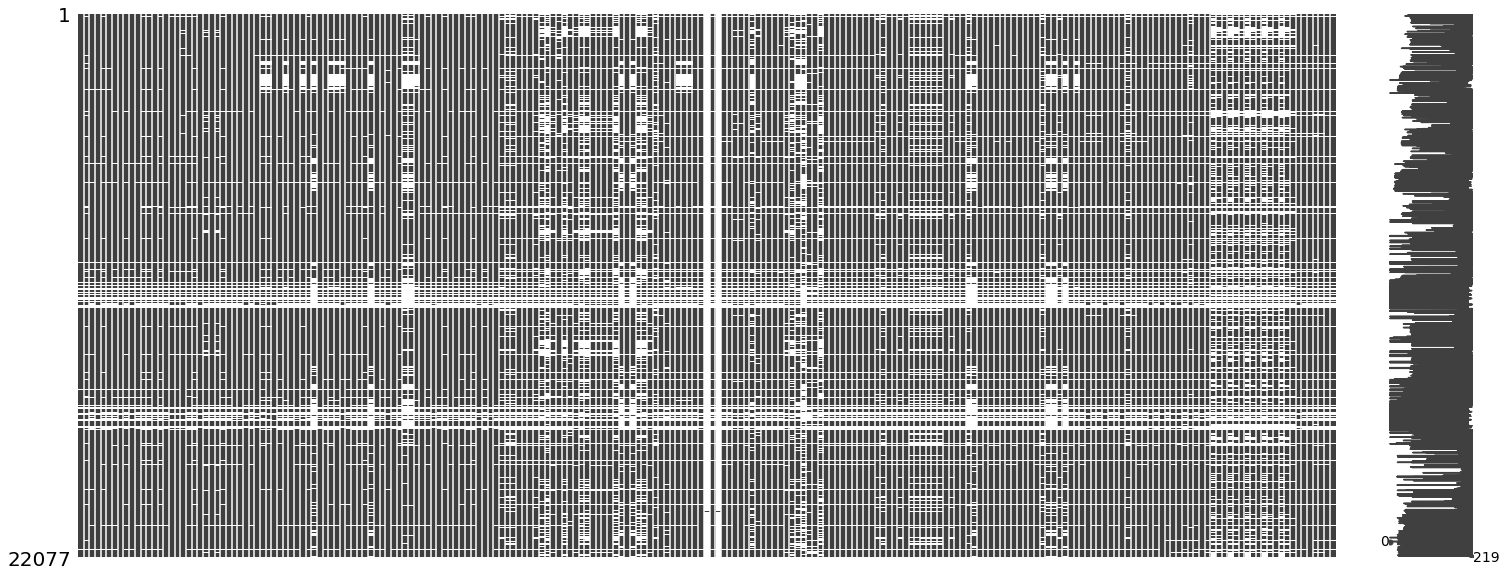

In [6]:
##### further exploration regarding NAs
#function to give back the column names and number of NAs of columns with more than a certain number of NAs
def name_gettr(data, treshold = 1500):
    res = {}
    for el in data[:1]:
        if data[el].isnull().sum() > treshold:
            res[el] = data[el].isnull().sum()
    return res

#apply function defined above
df14_outl = name_gettr(df14)
df15_outl = name_gettr(df15)
df16_outl = name_gettr(df16)
df17_outl = name_gettr(df17)
df18_outl = name_gettr(df18)


#create a list with dictionaries in order to run another function on them 
df_all_outl = [df14_outl, df15_outl, df16_outl, df17_outl, df18_outl]

#function which creates a list with all unique variables that have more than a certain number of NAs for at least one of the years of interest
def unique_high_NA (data):
    res = []
    for el in data:
        for e in el.keys():
            if not e in res:
                res.append(e)
    return(res)

#apply function and count number of variables to be retired from df
high_NA_vars = unique_high_NA(df_all_outl)
print(high_NA_vars)
len(unique_high_NA(df_all_outl)) #36 (out of 225, i.e. ~16%) variables


#graph showing percentages of values missing 
ratio_NA = df_all.isnull().sum()/len(df_all)
pd.Series.sort_values(ratio_NA)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_NA)+1), height = ratio_NA, width = 1, ec = 'black')
plt.ylabel('percentage missing values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_NA)+1), list(df14.columns), rotation = 90)


#missing value matrix where white lines indicate missing values
missingdata = df_all.columns[df_all.isnull().any()].tolist()
msno.matrix(df_all[missingdata])
    #we clearly see that e.g. for operatingCylce and cashConversionCycle we have a huge amount of NAs 
    #this is in harmony with the barplot above where we've seen this as well
    #what is also interesting is that some firms seem to have no or almost no data
    
#gives out the percentage of rows with an NA count of more than 150
high_col_nas = [ x for x in df_all.isnull().sum(axis=1) if x > 150]
len(high_col_nas)/len(df_all)
#high_col_nas

In [52]:
##### implementing a KNN imputation
imputer = KNNImputer(n_neighbors=20, weights='distance', metric='nan_euclidean', copy=True)

## df14
df14_Sector = df14['Sector'] #save the variable in case it is needed at some point along the way
df14_Stock = df14['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df14.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df14_imputed = imputer.fit_transform(df14)
df14_imputed = pd.DataFrame(df14_imputed)
df14_imputed.columns = list(df14)
df14_imputed.isnull().sum().sum()


# df15
df15_Sector = df15['Sector']
df15_Stock = df15['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df15.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df15_imputed = imputer.fit_transform(df15)
df15_imputed = pd.DataFrame(df15_imputed)
df15_imputed.columns = list(df15)
df15_imputed.isnull().sum().sum()


# df16
df16_Sector = df16['Sector']
df16_Stock = df16['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df16.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df16_imputed = imputer.fit_transform(df16)
df16_imputed = pd.DataFrame(df16_imputed)
df16_imputed.columns = list(df16)
df16_imputed.isnull().sum().sum()


# df17
df17_Sector = df17['Sector']
df17_Stock = df17['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df17.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df17_imputed = imputer.fit_transform(df17)
df17_imputed = pd.DataFrame(df17_imputed)
df17_imputed.columns = list(df17)
df17_imputed.isnull().sum().sum()


# df18
df18_Sector = df18['Sector']
df18_Stock = df18['Stock']
#careful with the following line as it has to be commented out if you were to run this chunk for a second time (since once we've dropped the variable 'Sector' we can obviously not drop it a second time)
df18.drop(['Sector', 'Stock'], axis = 1, inplace = True)

df18_imputed = imputer.fit_transform(df18)
df18_imputed = pd.DataFrame(df18_imputed)
df18_imputed.columns = list(df18)
df18_imputed.isnull().sum().sum()

0

<ipython-input-52-48e39183dec5>:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df14_imputed.Stock = df14_Stock


0

0

0

0

In [72]:
#df14_imputed.drop(['Stock'], axis = 1, inplace = True)
#df14_imputed.Stock = df14_Stock
#df14_imputed["Stock"] = df14_Stock
#df14_imputed['Stock']


#df14_imputed
#df14_Stock
#df14_imputed.insert(loc = 0, column = 'Stock', value = 0)
#df14_imputed['Stock'] = df14_Stock
#type(df14_Stock)

KeyError: 'Stock'

<Figure size 3600x1440 with 0 Axes>

[Text(1395.0, 978.48, 'X[50] <= 92302224.0\ngini = 0.49\nsamples = 3808\nvalue = [2174, 1634]'),
 Text(697.5, 761.0400000000001, 'X[128] <= 2.727\ngini = 0.475\nsamples = 3333\nvalue = [2036, 1297]'),
 Text(348.75, 543.6, 'X[18] <= 7382377.0\ngini = 0.449\nsamples = 2134\nvalue = [1407, 727]'),
 Text(174.375, 326.1600000000001, 'X[40] <= 17948.5\ngini = 0.336\nsamples = 327\nvalue = [257, 70]'),
 Text(87.1875, 108.72000000000003, 'gini = 0.261\nsamples = 227\nvalue = [192, 35]'),
 Text(261.5625, 108.72000000000003, 'gini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(523.125, 326.1600000000001, 'X[81] <= 7.74\ngini = 0.463\nsamples = 1807\nvalue = [1150, 657]'),
 Text(435.9375, 108.72000000000003, 'gini = 0.382\nsamples = 494\nvalue = [367, 127]'),
 Text(610.3125, 108.72000000000003, 'gini = 0.481\nsamples = 1313\nvalue = [783, 530]'),
 Text(1046.25, 543.6, 'X[48] <= 445779008.0\ngini = 0.499\nsamples = 1199\nvalue = [629, 570]'),
 Text(871.875, 326.1600000000001, 'X[204] <= 0.003\n

|--- Deposit Liabilities <= 92302224.00
|   |--- capitalExpenditureCoverageRatios <= 2.73
|   |   |--- Weighted Average Shs Out <= 7382377.00
|   |   |   |--- Tax assets <= 17948.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- Tax assets >  17948.50
|   |   |   |   |--- class: 0.0
|   |   |--- Weighted Average Shs Out >  7382377.00
|   |   |   |--- priceCashFlowRatio <= 7.74
|   |   |   |   |--- class: 0.0
|   |   |   |--- priceCashFlowRatio >  7.74
|   |   |   |   |--- class: 0.0
|   |--- capitalExpenditureCoverageRatios >  2.73
|   |   |--- Deferred revenue <= 445779008.00
|   |   |   |--- 3Y Operating CF Growth (per Share) <= 0.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- 3Y Operating CF Growth (per Share) >  0.00
|   |   |   |   |--- class: 1.0
|   |   |--- Deferred revenue >  445779008.00
|   |   |   |--- Capital Expenditure <= -205000000.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- Capital Expenditure >  -205000000.00
|   |   |   |   |--- class: 1.0
|--- Deposit

array([ 50, 128,  18,  40,  81,  48, 204,  63,   3,  59,  12,  61, 141,
        78, 137], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


priceCashFlowRatio    1053
dtype: int64

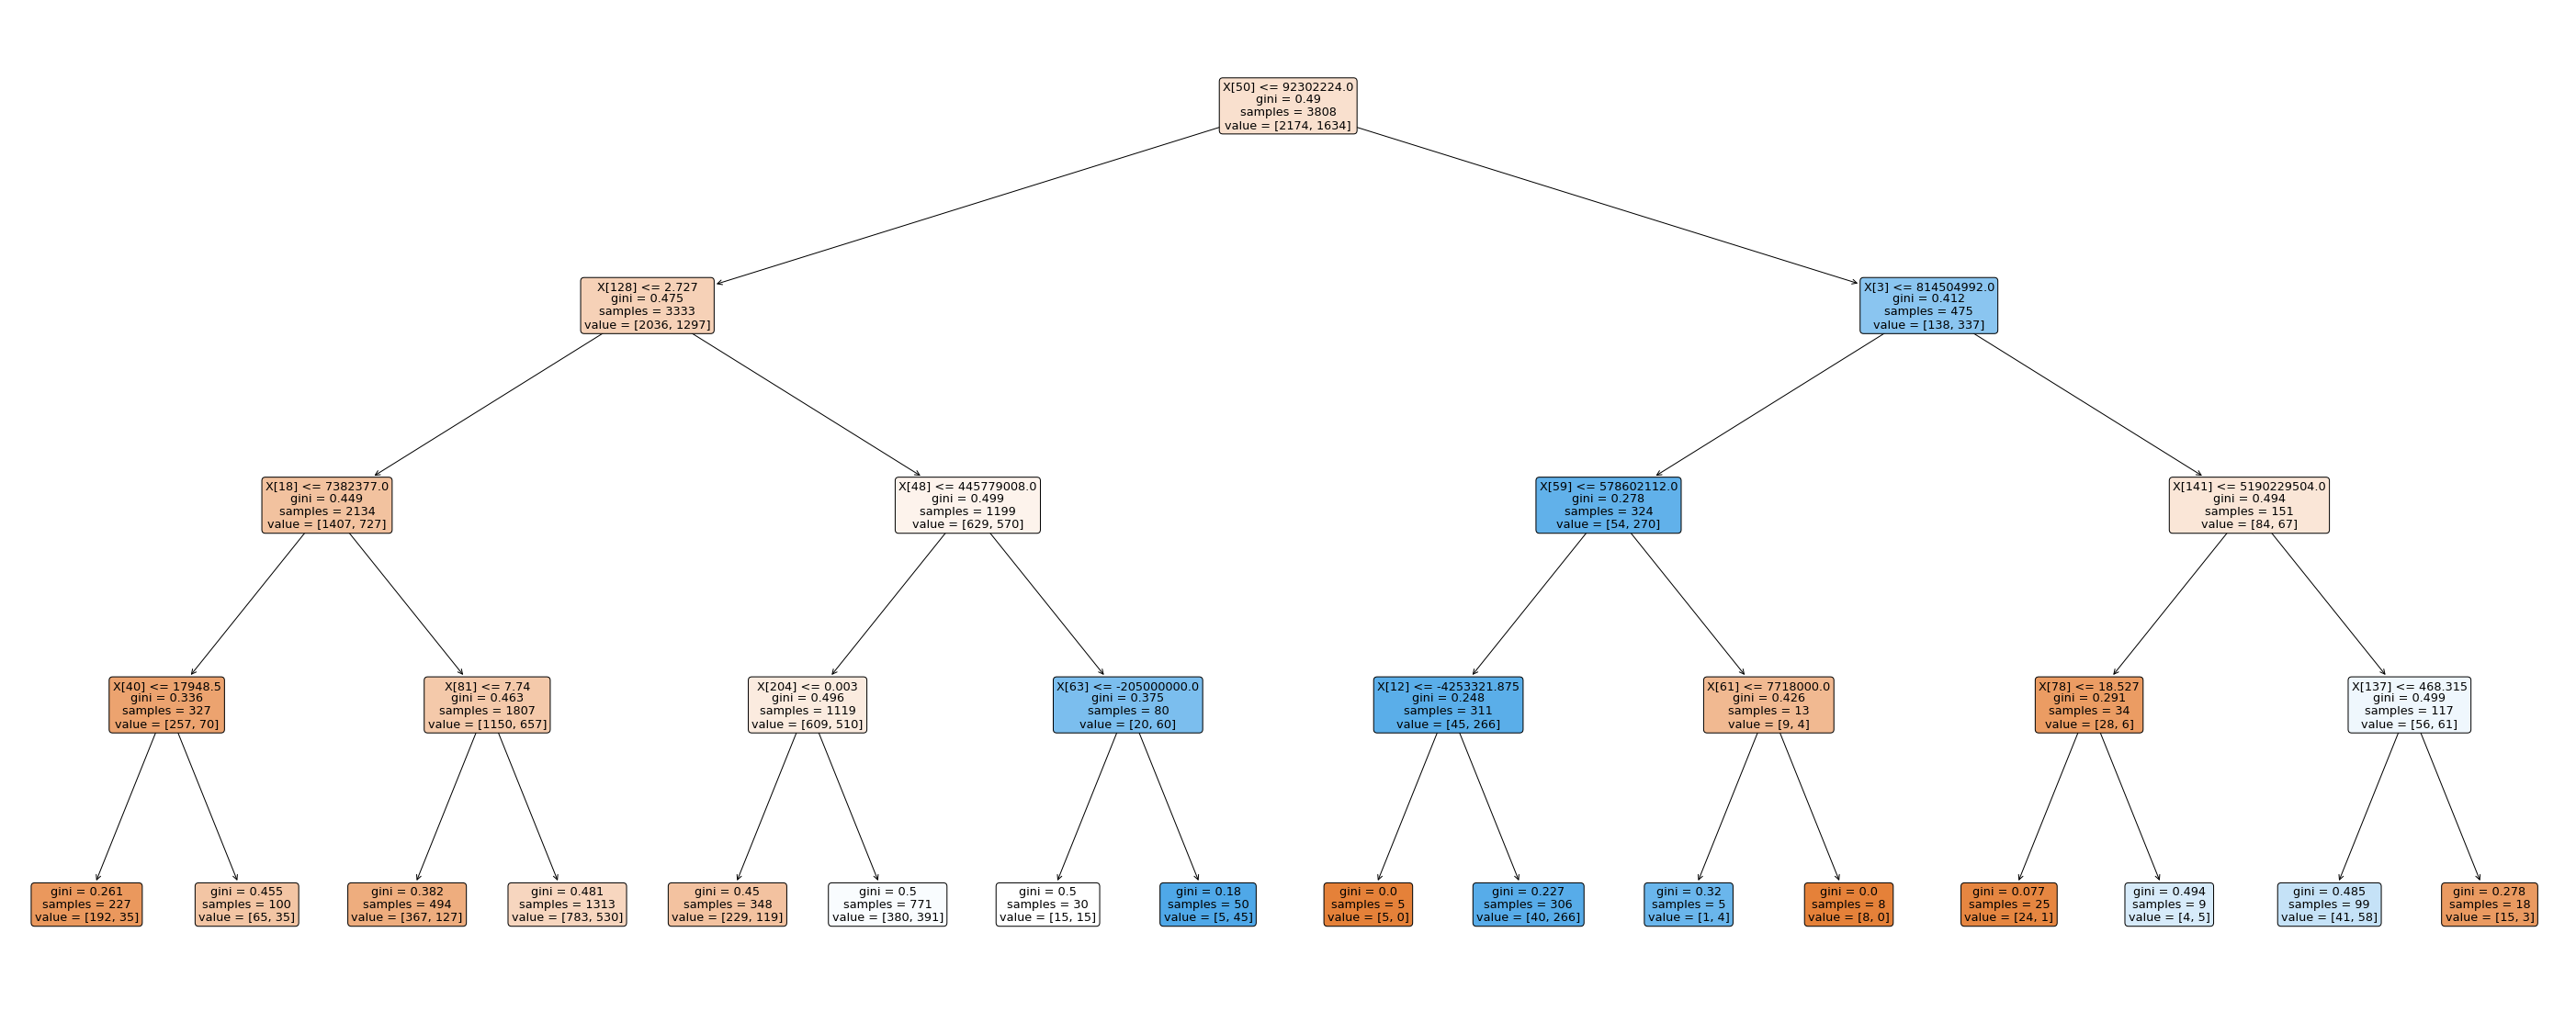

In [8]:
##### naive classification tree in order to see whether one of the variables ommitted is able to explain the dependent variable
Y = df14_imputed['Class']
X = df14_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4)
tree_fit_df14 = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
plot_tree(tree_fit_df14, filled = True, rounded = True)

#tree in text form
tree_text_df14 = export_text(tree_fit_df14, feature_names=list(X))
print(tree_text_df14)

#extract splitting features
tree_features_df14 = tree_fit_df14.tree_.feature
tree_features_df14 = tree_features_df14[tree_features_df14 != -2]
tree_features_df14



##### interpretation of the results from the desicion tree
#for df14:

#function to get the column names of the variables which were used to fit the decision tree
def imp_feat(data, idx): #imp_feat: important features
    res = []
    for el in idx:
        res.append(data.columns[el])
    return(res)

#apply above function to the data set
imp_feat_list_df14 = imp_feat(data = df14_imputed, idx = tree_features_df14)

#gives back a list of features which were used in the classification tree but have "a lot of" NAs
misfits_df14 = []
for el in imp_feat_list_df14:
    if el in high_NA_vars:
        misfits_df14.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df14[misfits_df14].isna().sum() #we see that apparently the three variables in the list 'misfits' do NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

In [9]:
#####for 15-18

#df15
Y = df15_imputed['Class']
X = df15_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df15 = tree.fit(X, Y)

#extract splitting features
tree_features_df15 = tree_fit_df15.tree_.feature
tree_features_df15 = tree_features_df15[tree_features_df15 != -2]
tree_features_df15

#apply function to get col names
imp_feat_list_df15 = imp_feat(data = df15_imputed, idx = tree_features_df15)

misfits_df15 = []
for el in imp_feat_list_df15:
    if el in high_NA_vars:
        misfits_df15.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df15[misfits_df15].isna().sum()


####################################################################################################
#df16
Y = df16_imputed['Class']
X = df16_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df16 = tree.fit(X, Y)

#extract splitting features
tree_features_df16 = tree_fit_df16.tree_.feature
tree_features_df16 = tree_features_df16[tree_features_df16 != -2]
tree_features_df16

#apply function to get col names
imp_feat_list_df16 = imp_feat(data = df16_imputed, idx = tree_features_df16)

misfits_df16 = []
for el in imp_feat_list_df16:
    if el in high_NA_vars:
        misfits_df16.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df16[misfits_df16].isna().sum()


####################################################################################################
#df17
Y = df17_imputed['Class']
X = df17_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df17 = tree.fit(X, Y)

#extract splitting features
tree_features_df17 = tree_fit_df17.tree_.feature
tree_features_df17 = tree_features_df17[tree_features_df17 != -2]
tree_features_df17

#apply function to get col names
imp_feat_list_df17 = imp_feat(data = df17_imputed, idx = tree_features_df17)

misfits_df17 = []
for el in imp_feat_list_df17:
    if el in high_NA_vars:
        misfits_df17.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df17[misfits_df17].isna().sum()


####################################################################################################
#df18
Y = df18_imputed['Class']
X = df18_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_df18 = tree.fit(X, Y)

#extract splitting features
tree_features_df18 = tree_fit_df18.tree_.feature
tree_features_df18 = tree_features_df18[tree_features_df18 != -2]
tree_features_df18

#apply function to get col names
imp_feat_list_df18 = imp_feat(data = df18_imputed, idx = tree_features_df18)

misfits_df18 = []
for el in imp_feat_list_df18:
    if el in high_NA_vars:
        misfits_df18.append(el)

print('features with high NA values (in at least one year) that are important according to the classification tree:')
df18[misfits_df18].isna().sum()



####################################################################################################
#for all the data

#create a list with all imputed data 
df_all_imputed = pd.concat([df14_imputed, df15_imputed, df16_imputed, df17_imputed, df18_imputed], ignore_index = True)


Y = df_all_imputed['Class']
X = df_all_imputed.drop(['Class', 'PRICE_VAR'], axis = 1)

#fit the tree
tree = DecisionTreeClassifier(random_state = 0 , max_depth = 4) #not necessary but for rigour's sake
tree_fit_all = tree.fit(X, Y)
plt.figure(figsize = (50, 20))
#plot_tree(tree_fit_all, filled = True, rounded = True)

#tree in text form
tree_text_all = export_text(tree_fit_all, feature_names=list(X))
#print(tree_text_all)

#extract splitting features
tree_features_all = tree_fit_all.tree_.feature
tree_features_all = tree_features_all[tree_features_all != -2]
tree_features_all


#apply function to get col names
imp_feat_list_all = imp_feat(data = df_all_imputed, idx = tree_features_all)

misfits = []
for el in imp_feat_list_all:
    if el in high_NA_vars:
        misfits.append(el)

        df_all[misfits].isna().sum() #we see that apparently the three variables in the list 'misfits' do NOT have more than the treshold value of NAs for the year 2014 (but for some other year)

array([ 22, 133,  69, 185,  96,  86,  65,  81, 160,  68, 127, 181, 104,
        30,  90], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


priceCashFlowRatio         1197
shortTermCoverageRatios    1925
dtype: int64

array([  7,  87, 139,  31, 170, 140,  17, 113,  39,  15, 164, 107, 206,
       216,  20], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


ROIC                                1602
5Y Net Income Growth (per Share)    1680
dtype: int64

array([ 86, 110,  44, 182,  12,  20,  23,  80, 151,  85,   3, 163, 204,
       215], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


operatingCycle             4955
enterpriseValueMultiple    1800
dtype: int64

array([174, 195, 143,  61,  38,  16,  68, 208,  81,  65,  16, 210,  24,
         8,  41], dtype=int64)

features with high NA values (in at least one year) that are important according to the classification tree:


10Y Shareholders Equity Growth (per Share)    1695
priceCashFlowRatio                            1256
Total non-current assets                      1041
dtype: int64

<Figure size 3600x1440 with 0 Axes>

array([110,  23, 100,  18, 140,  20,  41,  84, 221, 112, 110,  50,  92,
        42, 137], dtype=int64)

operatingCycle    22058
dtype: int64

operatingCycle              22058
Total non-current assets     6022
dtype: int64

operatingCycle              22058
Total non-current assets     6022
cashConversionCycle         22058
dtype: int64

operatingCycle              22058
Total non-current assets     6022
cashConversionCycle         22058
operatingCycle              22058
dtype: int64

<Figure size 3600x1440 with 0 Axes>

In [10]:
#consolidate all variables which are important for any of the five years
misfits_all = list(set(misfits_df14 + misfits_df15 + misfits_df16 + misfits_df17 + misfits_df18)) #set() in order to remove dublicates
misfits_all

df_temporary = [df14, df15, df16, df17, df18]
for el in df_temporary:
    print(el[misfits_all].isnull().sum(), "\n")

#from this output we conclude that:
    #even if operatingCycle would be able to predict future return, we have way too many NAs
    #also shortTermCoverageRatios and 10y Shareholder Equity Growth has too few values over all years, hence we remove it from the data set
    #we leave in the dataset the following:
        #priceCashFlowRatio
        #5Y Net Income Growth (per Share)
        #enterpriseValueMultiple
        #ROIC
        #Total non-current assets
        
        
        
##### dropping variables with too many NAs

#high_NA_vars #uncomment to see variables that have many NAs

notdrop = ['priceCashFlowRatio', '5Y Net Income Growth (per Share)', 'enterpriseValueMultiple', 'ROIC', 'Total non-current assets']
drop = [x for x in high_NA_vars if x not in notdrop]

df14_imputed.drop(drop, axis = 1, inplace = True)
df15_imputed.drop(drop, axis = 1, inplace = True)
df16_imputed.drop(drop, axis = 1, inplace = True)
df17_imputed.drop(drop, axis = 1, inplace = True)
df18_imputed.drop(drop, axis = 1, inplace = True)
df_all_imputed.drop(drop, axis = 1, inplace = True)

['priceCashFlowRatio',
 'ROIC',
 '10Y Shareholders Equity Growth (per Share)',
 'operatingCycle',
 'enterpriseValueMultiple',
 '5Y Net Income Growth (per Share)',
 'Total non-current assets',
 'shortTermCoverageRatios']

priceCashFlowRatio                            1053
ROIC                                           987
10Y Shareholders Equity Growth (per Share)    1585
operatingCycle                                3807
enterpriseValueMultiple                        944
5Y Net Income Growth (per Share)              1037
Total non-current assets                       908
shortTermCoverageRatios                       1956
dtype: int64 

priceCashFlowRatio                            1197
ROIC                                          1125
10Y Shareholders Equity Growth (per Share)    1766
operatingCycle                                4118
enterpriseValueMultiple                       1224
5Y Net Income Growth (per Share)              1214
Total non-current assets                      1029
shortTermCoverageRatios                       1925
dtype: int64 

priceCashFlowRatio                            1708
ROIC                                          1602
10Y Shareholders Equity Growth (per Share)    2286
o

### further imputing methods
* as the title suggests, here we tried to use different methods
* the first (and second) one is a method that is often used in R
* the third imputation here is based on the (still experimental) iterative imputer from the sklearn package

\
some links that we have found to be useful\
for the MissForest imputer: \
https://github.com/epsilon-machine/missingpy/blob/master/missingpy/missforest.py \
https://towardsdatascience.com/how-to-use-python-and-missforest-algorithm-to-impute-missing-data-ed45eb47cb9a

for the MICE imputer: \
https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.html \
https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22

general:\
https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

In [11]:
##### MissForest imputer

#make an instance and perform an imputation


imputer2 = MissForest(max_iter = 4, n_estimators = 10, max_depth = 5, n_jobs = -1, random_state = 3)
    #we have (rather dramatically) reduced some input parameters due to the high time complexity of this algorithm (a single iteration with those takes about 10mins on our laptops)

#df 14    
df14_imputed_ver2 = imputer2.fit_transform(df14)
df14_imputed_ver2 = pd.DataFrame(df14_imputed_ver2)
df14_imputed_ver2.columns = list(df14)
df14_imputed_ver2.isnull().sum().sum()


#df 15  
df15_imputed_ver2 = imputer2.fit_transform(df15)
df15_imputed_ver2 = pd.DataFrame(df15_imputed_ver2)
df15_imputed_ver2.columns = list(df15)
df15_imputed_ver2.isnull().sum().sum()


#df 16
df16_imputed_ver2 = imputer2.fit_transform(df16)
df16_imputed_ver2 = pd.DataFrame(df16_imputed_ver2)
df16_imputed_ver2.columns = list(df16)
df16_imputed_ver2.isnull().sum().sum()


#df 17
df17_imputed_ver2 = imputer2.fit_transform(df17)
df17_imputed_ver2 = pd.DataFrame(df17_imputed_ver2)
df17_imputed_ver2.columns = list(df17)
df17_imputed_ver2.isnull().sum().sum()


#df 18
df18_imputed_ver2 = imputer2.fit_transform(df18)
df18_imputed_ver2 = pd.DataFrame(df18_imputed_ver2)
df18_imputed_ver2.columns = list(df18)
df18_imputed_ver2.isnull().sum().sum()


#df_all
df_all_imputed_ver2 = imputer2.fit_transform(df_all)
df_all_imputed_ver2 = pd.DataFrame(df_all_imputed_ver2)
df_all_imputed_ver2.columns = list(df_all)
df_all_imputed_ver2.isnull().sum().sum()


KeyboardInterrupt: 

In [ ]:
##### MICE imputer

#df14_imputed_ver3 = mice.MICEData(df14)
#from fancyimpute import MICE
#imputer3 = MICE(verbose = False)
#df14_imputed_ver3 = imputer3.complete(df14)

    #cannot install module fancyimpute

In [ ]:
##### iterative imputer
df14.drop(drop, axis = 1, inplace = True)
iter_imp = IterativeImputer(estimator =  ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=10, verbose=False)
iter_imp.fit(df14)
df14_imputed_iter = iter_imp.transform(df14)
df14_imputed_iter = pd.DataFrame(df14_imputed_iter, columns=df14.columns)
    #never actually fully executed this code (terminated after it was still running after 30mins)


## Zero values
when going though the data one thing that came to attention was the many zeroes \
the question is how to handle those zeroes as some make more sense (e.g. 0 R&D Expenses for a gold mining company) while others are more ambiguous (e.g. revenue of 0, very few firms have negative revenues for the year 2014)

In [ ]:
##### inspection of 0-values

def name_gettr_zeroes(data, treshold = 500):
    res = {}
    for el in data[:1]:
        if data[el].isin([0]).sum() > treshold:
            res[el] = data[el].isin([0]).sum()
    return res


df14_zero_vals = list(df14.isin([0]).sum())
df14_zeroes = name_gettr_zeroes(df14)
print(df14_zeroes, '\n' ,'length =', len(df14_zeroes))


df15_zero_vals = df15.isin([0]).sum()
#df15_zero_vals

df16_zero_vals = df16.isin([0]).sum()
#df16_zero_vals

df17_zero_vals = df17.isin([0]).sum()
#df17_zero_vals

df18_zero_vals = df18.isin([0]).sum()
#df18_zero_vals




In [ ]:
#graph showing percentages of zero values

ratio_zeroes = df_all.isin([0]).sum()/len(df_all)
pd.Series.sort_values(ratio_zeroes)
plt.figure(figsize=(100, 30))
plt.bar(np.arange(1,len(ratio_zeroes)+1), height = ratio_zeroes, width = 1, ec = 'black')
plt.ylabel('percentage zero values', fontsize = 100)
plt.rc('ytick', labelsize=80)
plt.rc('xtick', labelsize=5)
plt.xticks(np.arange(1,len(ratio_zeroes)), list(df14.columns), rotation = 90)


In [ ]:
#plotting only the 20 columns with the most zero-values

total_zeroes = df_all.isin([0]).sum().sort_values(ascending=False)
percent_zeroes = (df_all.isin([0]).sum()/df_all.isin([0]).count()*100).sort_values(ascending=False)
df_zeroes = pd.concat([total_zeroes, percent_zeroes], axis = 1, keys = ['total zeroes', 'percent zeroes'])
plt.bar(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].values.tolist())
plt.xticks(np.arange(20), df_zeroes['percent zeroes'].iloc[:20].index.values.tolist(), rotation = 90)
plt.ylabel('percentage zero values (ordered)', fontsize = 12)
plt.rc('ytick', labelsize = 15)
plt.grid(alpha = 0.2, axis = 'y')
plt.show()

#we see that most features with a high percentage of zero values are plausable to be zero (e.g. Dividend/ R&D Expenses)
#we assume that those are not measurement errors/ missing values and hence we decide that those values should not be omitted
#note: however, this says nothing about the importance of these values

### Outliers
one more thing to consider before jumping into the process of fitting models are outliers \
the first and probably most prominent method is to cut off at some multiple of the stdv which however, requires the variables to follow a normal distribution (which is rather unlikely if I had to take an a priori guess)
another possibility is to work with the IQR method which is not in need of such a strong assumption

In [ ]:
##### checking for multivariate normality (Heinze-Zirkler test)
    #note: if we only had a handful of features we could use common methods like the Shapiro-Wilk test or even simple QQ-plots
print(pg.multivariate_normality(df14_imputed))


#Thus we see that the data is not, and I want to emphasise NOT, multivariate normal, according to the Heinze-Zirkler test
#i.e., we can not apply functions which are meant for Gaussian data



In [ ]:
#### IQR (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

#function that returns the IQR for each column of our data set
def IQR_gettr(data):
    IQR = {}
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR[el] = round(q75 - q25, 4)
    return IQR

#function that returns which variables have an IQR equal to 0, input must be a dictionary
def IQR_zeroes(dictionary):
    res = {}
    for key, val in dictionary.items():
        if not val:
            res[key] = dictionary[key]
    return res



df14_IQR = IQR_gettr(df14_imputed) #dictionary
df14_IQR_zeroes = IQR_zeroes(df14_IQR) #dictionary
        
df15_IQR = IQR_gettr(df15_imputed)
df15_IQR_zeroes = IQR_zeroes(df15_IQR)

df16_IQR = IQR_gettr(df16_imputed)
df16_IQR_zeroes = IQR_zeroes(df16_IQR)

df17_IQR = IQR_gettr(df17_imputed)
df17_IQR_zeroes = IQR_zeroes(df17_IQR)

df18_IQR = IQR_gettr(df18_imputed)
df18_IQR_zeroes = IQR_zeroes(df18_IQR)


In [ ]:
#input = imputed dataframe
#desired output = dataframe which took care of outliers, i.e., it restricts outliers to the IQR distance times 1.5

def IQR_outlier_manager(data):
    upper_lower_bound = {}
    
    for el in data.columns:
        q25 = np.percentile(np.array(data[el]), 25)
        q75 = np.percentile(np.array(data[el]), 75)
        IQR = (q75 - q25)
        
        upper_lower_bound[el] = [q75 + IQR * 1.5, q25 - IQR * 1.5]
        
    
    #until here we created a dictionary with the column name as the key and the
    #Interquantile distance (upper and lower borders, times a threshold (1.5)) as value
    
    outlier_count_lower = 0
    outlier_count_upper = 0
    
    res = {}
    
    
    for el in data.columns:
        upper = upper_lower_bound[el][0]
        lower = upper_lower_bound[el][1]
        
        res[el] = []
        #here we extract the upper and lower bound per column of the dataframe
        
        for e in data[el]:
            if e > upper:
                res[el].append(upper)
                outlier_count_upper += 1
            elif e < lower:
                res[el].append(lower)
                outlier_count_lower += 1
            else:
                res[el].append(e)
        #then we check whether the entries of the columns are larger or smaller than our borders, if so
        #we reset them to lie on the border, furthermore we count the amount of outliers overall
    
    res = pd.DataFrame.from_dict(res)
    #print(f"Amount of outliers below: {outlier_count_lower}\nAmount of outliers above: {outlier_count_upper}")
    return res

#Finally we return our new modified dataframe and the amount of outliers we counted (upper and lower separated)
    

In [ ]:
df14_imputed_outliercorrected = IQR_outlier_manager(df14_imputed)
df15_imputed_outliercorrected = IQR_outlier_manager(df15_imputed)
df16_imputed_outliercorrected = IQR_outlier_manager(df16_imputed)
df17_imputed_outliercorrected = IQR_outlier_manager(df17_imputed)
df18_imputed_outliercorrected = IQR_outlier_manager(df18_imputed)


# df14_imputed_outlier_corrected['Revenue'][3079]             #before
# df14_imputed['Revenue'][3079]                               #after

# np.percentile(df14_imputed['Revenue'], 75) + (np.percentile(df14_imputed['Revenue'], 75) - np.percentile(df14_imputed['Revenue'], 25)) * 1.5
# np.percentile(df14_imputed['Revenue'], 25) - (np.percentile(df14_imputed['Revenue'], 75) - np.percentile(df14_imputed['Revenue'], 25)) * 1.5



In [ ]:
#convert df_all_imputed to a dataframe
df_all_imputed = pd.DataFrame(df_all_imputed)

#we create a oultier-corrected dataframe over all five years (IQR Method)
df_all_imputed_outliercorrected = IQR_outlier_manager(df_all_imputed)
df_all_imputed_outliercorrected

In [ ]:
#another method for outlier handling
#idea: reset top 5% and bottom 5% to the 5. and 95. percentile
#conceptionally the same approach with a less radical cut-off

df14_top5_outliers = df14_imputed.quantile(.95)
df14_bottom5_outliers = df14_imputed.quantile(.05)

df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed > df14_top5_outliers, df14_top5_outliers, axis=1)
df14_imputed_outliercorrected_ver2 = df14_imputed.mask(df14_imputed < df14_bottom5_outliers, df14_bottom5_outliers, axis=1)

# df14_imputed_outliercorrected_ver2.describe()
# df14_imputed_outliercorrected.describe()

#for df15
df15_top5_outliers = df15_imputed.quantile(.95)
df15_bottom5_outliers = df15_imputed.quantile(.05)

df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed > df15_top5_outliers, df15_top5_outliers, axis=1)
df15_imputed_outliercorrected_ver2 = df15_imputed.mask(df15_imputed < df15_bottom5_outliers, df15_bottom5_outliers, axis=1)


#for df16
df16_top5_outliers = df16_imputed.quantile(.95)
df16_bottom5_outliers = df16_imputed.quantile(.05)

df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed > df16_top5_outliers, df16_top5_outliers, axis=1)
df16_imputed_outliercorrected_ver2 = df16_imputed.mask(df16_imputed < df16_bottom5_outliers, df16_bottom5_outliers, axis=1)


#for df17
df17_top5_outliers = df17_imputed.quantile(.95)
df17_bottom5_outliers = df17_imputed.quantile(.05)

df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed > df17_top5_outliers, df17_top5_outliers, axis=1)
df17_imputed_outliercorrected_ver2 = df17_imputed.mask(df17_imputed < df17_bottom5_outliers, df17_bottom5_outliers, axis=1)


#for df18
df18_top5_outliers = df18_imputed.quantile(.95)
df18_bottom5_outliers = df18_imputed.quantile(.05)

df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed > df18_top5_outliers, df18_top5_outliers, axis=1)
df18_imputed_outliercorrected_ver2 = df18_imputed.mask(df18_imputed < df18_bottom5_outliers, df18_bottom5_outliers, axis=1)


## collection of thougts
### Imputing

possible ways of imputing:
* dropna() -> not very elaborate, dropping all NAs would result in a major data waste
* fillna() -> very simplistic method, probably not appropriate
* imputing with mean values -> [...] [T]he correlation structure of a dataset may not be captured if the decision is to plug missing values with zeros or with mean value over the samples. (Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, 2019, s. 52)
* imputing with median values
* imputing with most frequent value
* imputing with mean/median/most frequent value of each of the sectors (assuming macro-trends and macro-factors within each sector)
* KNN imputation
* iterative imputer (scikit-learn)


possible papers:
* A review on missing value estimation using imputation algorithm, Journal of Physics ConferenceSeries
* Gautrain, C., & Ravi, V. (2015). Data imputation via evolutionary computation,clustering and a neural network. Neurocomputing, 156:134-142
* Ping, X. O., Lai F., Tseng Y.J, Liang J. D., Huang G. T., Yang, P.M. (2014).Evaluation of imputation methods for missing data and their eﬀect on thereliability of predictive models. International Conference on Bioinformatics,Biocomputational Systems and Biotechnologies, 6, 8-14.
* Schmitt, P; Mandel, J; & Guedj, M. (2015). A comparison of six methods formissing data imputation. Journal of Biometrics & Biostatistics, 6(224), 1-6.
* Imputation of Missing Values in Economic and Financial Time Series Data Using Five Principal Component Analysis (PCA) Approaches, August 2019, Central Bank of Ntigeria Journal of Applied Statistics, DOI: 10.33429/Cjas.10119.3/6
* IMPUTATION OF MISSING VALUES IN THE FUNDAMENTAL DATA: UNLEASHING MICE FRAMEWORK

other help/links:
* https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

approach:
* multiple imputation (i.e. apply several imputation methods and analyse how the different methods affects performance of the algorithm)

### Zero values
* treat as NAs or simply as "zeroes"?
* maybe mixed? depending on 

### Topics to consider
* imputing
    * (e.g. KNN, https://www.kaggle.com/priyankasachdeva20/catboost-model-to-classify-buy-or-sell-stocks/comments line 11)
    * https://scikit-learn.org/stable/modules/impute.html
    * perhaps different methods for different variables
* 0s in df
* outliers
    * Z score - not the right approach, since it assumes normality which is violated
    * IQR
    * 90% Winsorisation - top and bottom 5% handled as outliers



* selection of relevant ratios/fundamental data
    * remove variables which are heavily correlated to each other (see line 7 in https://www.kaggle.com/mikevasi/risk-aversion-in-the-stock-market)
* feature engineering 
    * https://www.nber.org/system/files/working_papers/w25398/w25398.pdf (Dacheng, Empirical Asset Pricing via ML)
    * momentum?
    * categorical variable for market cap
* class imbalance
    * use the stratify option available within sklearn.model_selection.train_test_split
* analysis